# H-SAF Soil Moisture Week 2019
Exercise - Application for analyzing time-series

In this exercise we will

* Get ASCAT Data Record, ERA5 time-series and RZSM time-series
* Move the data into the correct location
* Read time-series data
* Visualize time-series
* Extract data for a given gpi point and date
* Performing some analysis using soil moisture, SWI index and rainfall data

**Metop ASCAT CDR 12.5 km sampling (2007-2017) H113**
1. sm -- soil moisture [%]
2. frozen_probability -- frozen soil probability H %]
3. snow_probability -- snow cover probability [%]
4. time -- time step [daily]

**ECMWF ERA5 TimeSeries 30 km grid (2000-)**
1. tp -- total precipitation [mm]
2. skt -- skin temperature [K]
3. time -- time step [hourly]

**ECMWF RZSM DataRecord 16 km resolution (1992-2014) H27**
1. var40 -- root zone soil moisture - level 1 - 0-7 cm
2. var41 -- root zone soil moisture - level 2 - 7-28 cm
3. var42 -- root zone soil moisture - level 3 - 28-100 cm
4. var43 -- root zone soil moisture - level 4 - 100-289 cm
5. time -- time step [daily]

All datasets are converted in time-series format following the WARP5 grid schematization. It stores the time series in 5x5 degree cells. This means there will be 2566 cell files (without reduction to land points) and a file called grid.nc which contains the information about which grid point is stored in which file.

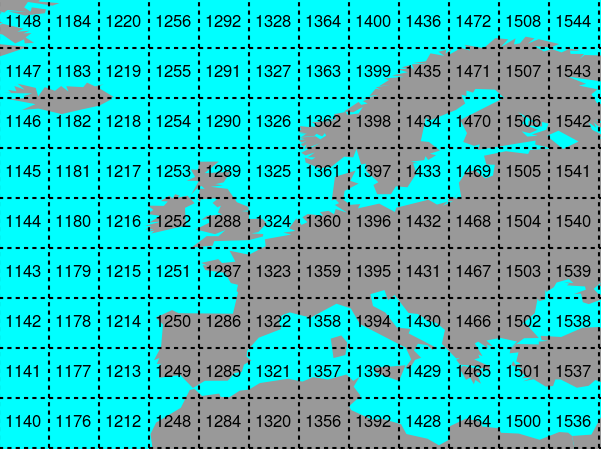

Each cell contains gpis that are id locations identified by longitude and latitude coordinates.
Using [grid_point_locator](http://rs.geo.tuwien.ac.at/dv/dgg/) you can retrieve gpis information for selected domain.

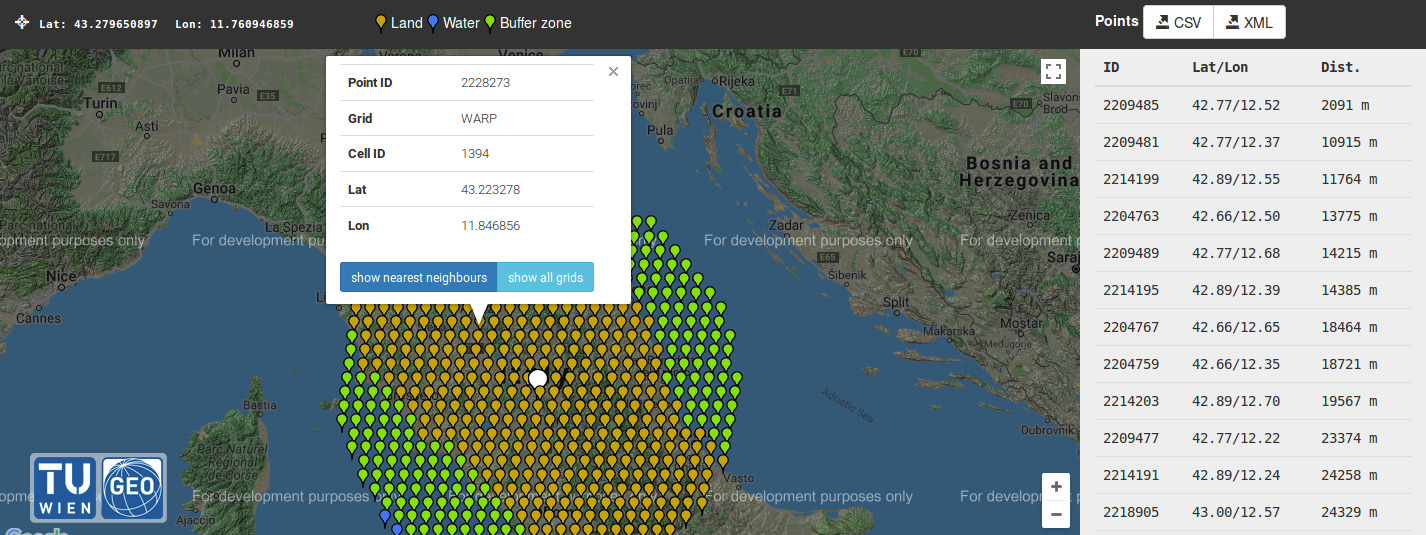
***

### Libraries

In [77]:
%matplotlib inline

# Libraries
import os
import warnings
import numpy as np
import pandas as pd

from os.path import join

from library.cima.domain_utils import get_grid, get_file_shp, get_file_json, create_points_shp
from library.cima.ts_utils import df_time_matching, df_temporal_matching, df_period_selection
from library.cima.ts_dset_reader import dset_init, dset_config, dset_period

from pytesmo.scaling import get_scaling_function, get_scaling_method_lut

from pytesmo.time_series.filters import exp_filter
from pytesmo.time_series import anomaly

import matplotlib.pyplot as plt

# Info
print('Libraries loaded!')
# Filter warnings in notebook
warnings.filterwarnings("ignore")

Libraries loaded!


### Exercise Configuration
In the configuration part:
* select your basin
* set correct paths of the data
* select time period of datasets
* set thresholds of snow and frozen conditions to filter ASCAT dataset

An example about how to organize static and dynamic data is reported.
- **structure of static data**: shapefile and grid files
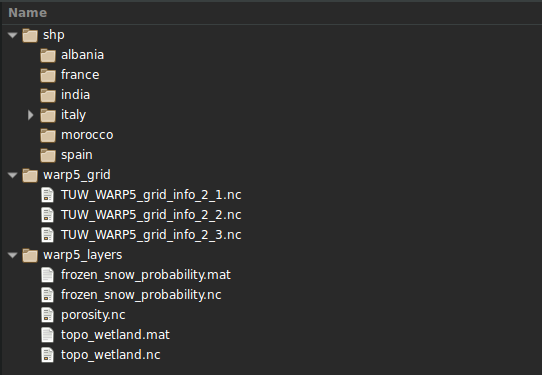

- **structure of dynamic data**: ASCAT, ERA5 and RZSM datasets
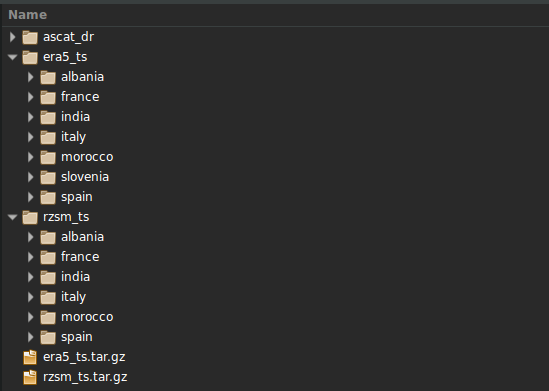

In [78]:
# Domain
domain = 'italy'
exercize = 'ex_time_series'
file_shp_domain = 'tiber_basin.shp'

# Path(s)
root_path='/home/fabio/Desktop/PyCharm_Workspace/fp-labs/hsaf_event_week_2019/'

data_path_dyn = os.path.join(root_path,'test_data', 'dynamic')
data_path_static = os.path.join(root_path,'test_data', 'static')

tmp_path = os.path.join(root_path, 'test_outcome', 'tmp', exercize)
img_path = os.path.join(root_path, 'test_outcome', 'img', exercize)
ancillary_path = os.path.join(root_path, 'test_outcome', 'ancillary', exercize)

ascat_path_ts = os.path.join(data_path_dyn, 'ascat_dr', domain)
ascat_path_grid = os.path.join(data_path_static, 'warp5_grid')
ascat_path_layers = os.path.join(data_path_static, 'warp5_layers')
ascat_path_tmp = os.path.join(tmp_path, 'ascat')

era5_path_ts = os.path.join(data_path_dyn, 'era5_ts', domain)
era5_path_grid = os.path.join(data_path_dyn, 'era5_ts', domain)
era5_path_tmp = os.path.join(tmp_path, 'era5')

rzsm_path_ts = os.path.join(data_path_dyn, 'rzsm_ts', domain)
rzsm_path_grid = os.path.join(data_path_dyn, 'rzsm_ts', domain)
rzsm_path_tmp = os.path.join(tmp_path, 'rzsm')

domain_path_layer = os.path.join(data_path_static, 'shp', domain)

# Parameters
ascat_mask_frozen_prob_threshold = 100 # if mask value is greater than threshold the value is discarded
ascat_mask_snow_prob_threshold = 100   # if mask value is greater than threshold the value is discarded

time_start = "2007-01-01" # format "%Y-%m-%d"
time_end = "2014-12-31"   # "format %Y-%m-%d"  

temporal_matching = 24
temporal_drop_duplicates = False

max_dist = 35000
                                 
# Create img path
if not os.path.exists(img_path):
    os.makedirs(img_path)
# Create ancillary path
if not os.path.exists(ancillary_path):
    os.makedirs(ancillary_path)
# Create tmp path
if not os.path.exists(tmp_path):
    os.makedirs(tmp_path)
 # Create tmp path for ascat
if not os.path.exists(ascat_path_tmp):
    os.makedirs(ascat_path_tmp)
# Create tmp path for era5
if not os.path.exists(era5_path_tmp):
    os.makedirs(era5_path_tmp)
 # Create tmp path for rzsm
if not os.path.exists(rzsm_path_tmp):
    os.makedirs(rzsm_path_tmp)

### Scaling methods
Available methods on pytesmo package are:
* **min-max correction** (min_max) - scales the input datasets so that they have the same minimum and maximum afterward
* **linear rescaling** (mean_std) - scales the input datasets so that they have the same mean and standard deviation afterwards
* **linear regression** (linreg) - scales the input datasets using linear regression
* **cdf matching** (cdf_match) - computes cumulative density functions of src and ref at their respective bin-edges by 5th order spline interpolation; then matches CDF of src to CDF of ref
* **linear cdf matching** (lin_cdf_match) - computes cumulative density functions of src and ref at their respective bin-edges by linear interpolation; then matches CDF of src to CDF of ref

In [79]:
# Get scaling methods available on pytesmo
scaling_methods = get_scaling_method_lut()
# Print available methods
print(list(scaling_methods.keys()))

['linreg', 'mean_std', 'min_max', 'lin_cdf_match', 'cdf_match']


In [80]:
# Get scaling method
scaling_method_lr = get_scaling_function('linreg')
scaling_method_ms = get_scaling_function('mean_std')

### Basin Configuration
The script loads the shapefile of the basin and creates a mask using the defined cell_size (degree) and boudary box buffer (bbox_ext in degree). 
After running the cell, results can be check using QGIS. 

In [81]:
# Get basin information using a shapefile
basin_rows, basin_cols, basin_epsg, basin_transform, basin_meta_reference = get_file_shp(
    os.path.join(domain_path_layer, file_shp_domain),
    os.path.join(ancillary_path, 'basin_domain.tiff'),
    cell_size=0.05, bbox_ext=0)
# Print information about basin 
print(basin_rows, basin_cols, basin_epsg, basin_transform)

24 21 EPSG:4326 | 0.05, 0.00, 11.89|
| 0.00,-0.05, 43.82|
| 0.00, 0.00, 1.00|


In [82]:
# Create basin grid using WARP5 reference system
basin_grid, basin_lons_2d, basin_lats_2d, basin_bbox = get_grid(
    os.path.join(img_path, 'basin_domain.tiff')) 
# Print information about basin 
print(basin_bbox)
# Using QGIS to:
# 1) load basin shapefile
# 2) load basin tiff
# 3) check results

RasterioIOError: /home/fabio/Desktop/PyCharm_Workspace/fp-labs/hsaf_event_week_2019/test_outcome/img/ex_time_series/basin_domain.tiff: No such file or directory

### Datasets configuration
In this part ASCAT, ERA5 and RZSM datasets are configured using parameters and paths set previously.
- Step 1 -- Create settings dictionary to summarize information about datasets

In [83]:
# Create ASCAT, ERA5 and RZSM settings
settings = {  
    "ascat_path_ts": ascat_path_ts,
    "ascat_path_grid": ascat_path_grid,
    "ascat_path_layer": ascat_path_layers,
    "ascat_path_tmp": ascat_path_tmp,
    "ascat_mask_frozen_prob_threshold": ascat_mask_frozen_prob_threshold,
    "ascat_mask_snow_prob_threshold": ascat_mask_snow_prob_threshold,
    "era5_path_ts": era5_path_ts,
    "era5_path_grid": era5_path_grid,
    "era5_path_tmp": era5_path_tmp,
    "rzsm_path_ts": rzsm_path_ts,
    "rzsm_path_grid": rzsm_path_grid,
    "rzsm_path_tmp": rzsm_path_tmp,
    "domain_path_layer": domain_path_layer,
    "time_start": time_start,
    "time_end": time_end,
    "temporal_matching": temporal_matching,
    "temporal_drop_duplicates": temporal_drop_duplicates,
    "max_dist": max_dist
}
# Print information about ASCAT and ERA5 settings
for key, value in settings.items():
    print(str(key) + ": " + str(settings[key]))

ascat_path_ts: /home/fabio/Desktop/PyCharm_Workspace/fp-labs/hsaf_event_week_2019/test_data/dynamic/ascat_dr/italy
ascat_path_grid: /home/fabio/Desktop/PyCharm_Workspace/fp-labs/hsaf_event_week_2019/test_data/static/warp5_grid
ascat_path_layer: /home/fabio/Desktop/PyCharm_Workspace/fp-labs/hsaf_event_week_2019/test_data/static/warp5_layers
ascat_path_tmp: /home/fabio/Desktop/PyCharm_Workspace/fp-labs/hsaf_event_week_2019/test_outcome/tmp/ex_time_series/ascat
ascat_mask_frozen_prob_threshold: 100
ascat_mask_snow_prob_threshold: 100
era5_path_ts: /home/fabio/Desktop/PyCharm_Workspace/fp-labs/hsaf_event_week_2019/test_data/dynamic/era5_ts/italy
era5_path_grid: /home/fabio/Desktop/PyCharm_Workspace/fp-labs/hsaf_event_week_2019/test_data/dynamic/era5_ts/italy
era5_path_tmp: /home/fabio/Desktop/PyCharm_Workspace/fp-labs/hsaf_event_week_2019/test_outcome/tmp/ex_time_series/era5
rzsm_path_ts: /home/fabio/Desktop/PyCharm_Workspace/fp-labs/hsaf_event_week_2019/test_data/dynamic/rzsm_ts/italy
rzs

* Step 2 -- Initialize and configure reader objects for ASCAT, ERA5 and RZSM datasets

In [84]:
# Initialize ASCAT, ERA5, RZSM datasets
reader_ascat, reader_era5, reader_rzsm = dset_init(settings)
datasets = dset_config(reader_ascat, reader_era5, reader_rzsm, settings)
# Print information about ASCAT and ERA5 datasets
print("ASCAT dataset settings: " + str(datasets["ASCAT"]))
print("ERA5 dataset settings: " + str(datasets["ERA5"]))
print("RZSM dataset settings: " + str(datasets["RZSM"]))

ASCAT dataset settings: {'class': <library.cima.ts_dset_driver.ASCAT_Dataset_DR object at 0x7fe5d4f85c88>, 'columns': ['sm'], 'type': 'reference', 'args': [], 'kwargs': {'mask_frozen_prob': 100, 'mask_snow_prob': 100}}
ERA5 dataset settings: {'class': <library.cima.ts_dset_driver.ERA5_Dataset_TS object at 0x7fe5d4f85be0>, 'columns': ['tp', 'tsk'], 'type': 'other', 'grids_compatible': False, 'use_lut': True, 'lut_max_dist': 35000}
RZSM dataset settings: {'class': <library.cima.ts_dset_driver.RZSM_Dataset_TS object at 0x7fe5d4fce2e8>, 'columns': ['var40', 'var41', 'var42', 'var43'], 'type': 'other', 'grids_compatible': False, 'use_lut': True, 'lut_max_dist': 35000}


- Step 3 -- Find GPIS of ASCAT, ERA5 and RZSM datasets using basin reference

In [85]:
# Create ASCAT and ERA5 grid(s) using basin information
# Get ascat gpi(s)
gpis_ascat, lats_ascat, lons_ascat = reader_ascat.grid.get_bbox_grid_points(
    latmin=basin_bbox.bottom, latmax=basin_bbox.top, lonmin=basin_bbox.left,
    lonmax=basin_bbox.right, both=True)
gpis_ascat_n = gpis_ascat.__len__()
# Get era5 gpi(s)
gpis_era5, lats_era5, lons_era5 = reader_era5.grid.get_bbox_grid_points(
    latmin=basin_bbox.bottom, latmax=basin_bbox.top, lonmin=basin_bbox.left,
    lonmax=basin_bbox.right, both=True)
gpis_era5_n = gpis_era5.__len__()
# Get rzsm gpi(s)
gpis_rzsm, lats_rzsm, lons_rzsm = reader_rzsm.grid.get_bbox_grid_points(
    latmin=basin_bbox.bottom, latmax=basin_bbox.top, lonmin=basin_bbox.left,
    lonmax=basin_bbox.right, both=True)
gpis_rzsm_n = gpis_rzsm.__len__()

# Print information about ASCAT, ERA5 and RZSM gpi(s) numerosity
print("ASCAT GPIS N: " + str(gpis_ascat_n))
print("ERA5 GPIS N: " + str(gpis_era5_n))
print("RZSM GPIS N: " + str(gpis_rzsm_n))

ASCAT GPIS N: 76
ERA5 GPIS N: 20
RZSM GPIS N: 72


- Step 4 -- Verify, for each dataset, if there are enough gpis inside the basin.
Using QGIS, load the created shapefiles and results should be as follows.
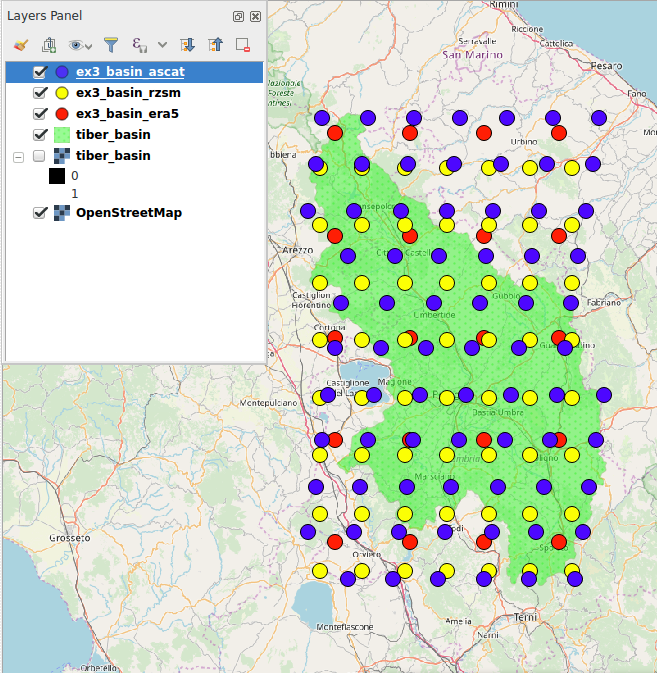

In [86]:
# Find ASCAT gpi(s) over basin (using a maximum distance parameter)
luts_ascat = reader_ascat.grid.calc_lut(basin_grid, max_dist=settings['max_dist'])
gpis_basin_ascat = np.unique(luts_ascat[gpis_ascat])
lons_basin_ascat, lats_basin_ascat = basin_grid.gpi2lonlat(gpis_basin_ascat)
# Create shapefile of ASCAT gpi(s) over basin
create_points_shp(gpis_basin_ascat, lons_basin_ascat, lats_basin_ascat, 
                  file_name_shp=os.path.join(ancillary_path, 'basin_ascat.shp'))
# Print ASCAT gpi(s) ID
print("ASCAT Basin GPIS: " + str(gpis_basin_ascat))

ASCAT Basin GPIS: [ 22  25  28  31  34  37  40  66  70  73  76  79  82  85 111 114 117 120
 123 126 129 177 180 183 187 190 193 196 222 225 228 231 234 237 240 266
 269 272 275 279 282 285 311 314 317 320 323 326 374 377 380 383 386 389
 393 418 422 425 428 431 434 437 463 466 469 472 475 478 482 507 510 514
 517 520 523 526]


In [87]:
# Find ERA5 gpi(s) over basin (using a maximum distance parameter)
luts_era5 = reader_era5.grid.calc_lut(basin_grid, max_dist=settings['max_dist'])
gpis_basin_era5 = np.unique(luts_era5[gpis_era5])
lons_basin_era5, lats_basin_era5 = basin_grid.gpi2lonlat(gpis_basin_era5)
# Create shapefile of ERA5 gpi(s) over basin
create_points_shp(gpis_basin_era5, lons_basin_era5, lats_basin_era5, 
                  file_name_shp=os.path.join(ancillary_path, 'basin_era5.shp'))
# Print ERA5 gpi(s) ID
print("ERA5 Basin GPIS: " + str(gpis_basin_era5))

ERA5 Basin GPIS: [ 68  73  78  83 178 183 188 193 288 293 298 303 398 403 408 413 508 513
 518 523]


In [88]:
# Find RZSM gpi(s) over basin (using a maximum distance parameter)
luts_rzsm = reader_rzsm.grid.calc_lut(basin_grid, max_dist=settings['max_dist'])
gpis_basin_rzsm = np.unique(luts_rzsm[gpis_rzsm])
lons_basin_rzsm, lats_basin_rzsm = basin_grid.gpi2lonlat(gpis_basin_rzsm)
# Create shapefile of RZSM gpi(s) over basin
create_points_shp(gpis_basin_rzsm, lons_basin_rzsm, lats_basin_rzsm, 
                  file_name_shp=os.path.join(ancillary_path, 'basin_rzsm.shp'))
# Print RZSM gpi(s) ID
print("RZSM Basin GPIS: " + str(gpis_basin_rzsm))

RZSM Basin GPIS: [ 23  26  29  32  35  37  40  43  89  92  95  98 101 103 106 109 155 158
 161 164 167 169 172 175 221 224 227 230 233 235 238 241 287 290 293 296
 299 301 304 307 331 334 337 340 343 345 348 351 397 400 403 406 409 411
 414 417 463 466 469 472 475 477 480 483 529 532 535 538 541 543 546 549]


- Step 5 -- Find gpis of ERA5 and RZSM using ASCAT as reference dataset

In [89]:
# Get ERA5 gpis using RZSM reference grid
luts_rzsm_era5 = reader_era5.grid.calc_lut(reader_rzsm.grid, max_dist=settings['max_dist'])
gpis_rzsm_era5 = np.unique(luts_rzsm_era5[gpis_era5])
lons_rzsm_era5, lats_rzsm_era5 = reader_rzsm.grid.gpi2lonlat(gpis_rzsm_era5)

# Define ASCAT, ERA5 and RZSM common gpis
gpis_ascat_ws = reader_ascat.grid.find_nearest_gpi(lons_rzsm_era5, lats_rzsm_era5, max_dist=settings['max_dist'])
gpis_ascat = gpis_ascat_ws[0]; dist_ascat = gpis_ascat_ws[1];
lons_ascat, lats_ascat = reader_ascat.grid.gpi2lonlat(gpis_ascat)

gpis_era5_ws = reader_era5.grid.find_nearest_gpi(lons_ascat, lats_ascat, max_dist=settings['max_dist'])
gpis_era5 = gpis_era5_ws[0]; dist_era5 = gpis_era5_ws[1];
lons_era5, lats_era5 = reader_era5.grid.gpi2lonlat(gpis_era5)

gpis_rzsm_ws = reader_rzsm.grid.find_nearest_gpi(lons_ascat, lats_ascat, max_dist=settings['max_dist'])
gpis_rzsm = gpis_rzsm_ws[0]; dist_rzsm = gpis_rzsm_ws[1];
lons_rzsm, lats_rzsm = reader_rzsm.grid.gpi2lonlat(gpis_rzsm)

### Extract ASCAT,  ERA5 and RZSM datasets
Once datasets are prepared, select two gpis, extract the time-series and perform the requested analysis 
* save latitude and longitude information
* create a shapefile using QGIS to plot gpi position

In [90]:
# GPIS TimeSeries 1 - Choose an index to select ASCAT, ERA5 and RZSM gpi (example --> idx=5)
idx=1
gpi_ascat_id1 = gpis_ascat[idx]
gpi_era5_id1 = gpis_era5[idx]
gpi_rzsm_id1 = gpis_rzsm[idx]
# Print gpis values
print('ID1 ==> ASCAT gpi: ' + str(gpi_ascat_id1) + ' -- ERA5 gpi: ' + str(gpi_era5_id1) + ' -- RZSM gpi: ' + str(gpi_rzsm_id1))
lon_ascat_id1, lat_ascat_id1 = reader_ascat.grid.gpi2lonlat(gpi_ascat_id1)

ID1 ==> ASCAT gpi: 2204755 -- ERA5 gpi: 1454 -- RZSM gpi: 4751


In [91]:
# GPIS TimeSeries 2 - Choose an index to select ASCAT, ERA5 and RZSM gpi (example --> idx=5)
idx=7
gpi_ascat_id2= gpis_ascat[idx]
gpi_era5_id2 = gpis_era5[idx]
gpi_rzsm_id2 = gpis_rzsm[idx]
# Print gpis values
print('ID2 ==> ASCAT gpi: ' + str(gpi_ascat_id2) + ' -- ERA5 gpi: ' + str(gpi_era5_id2) + ' -- RZSM gpi: ' + str(gpi_rzsm_id2))
lon_ascat_id2, lat_ascat_id2 = reader_ascat.grid.gpi2lonlat(gpi_ascat_id2)

ID2 ==> ASCAT gpi: 2218909 -- ERA5 gpi: 1399 -- RZSM gpi: 4954


In [92]:
# Save selected points to check positions on the map
create_points_shp([gpi_ascat_id1, gpi_ascat_id2], [lon_ascat_id1, lon_ascat_id2], [lat_ascat_id1, lat_ascat_id2], 
                  file_name_shp=os.path.join(ancillary_path, 'basin_ascat_points.shp'))

Using QGIS, check if gpi 1 and 2 are over basin and, if needed, change your choice. Results should be analyzed using a map as follows.
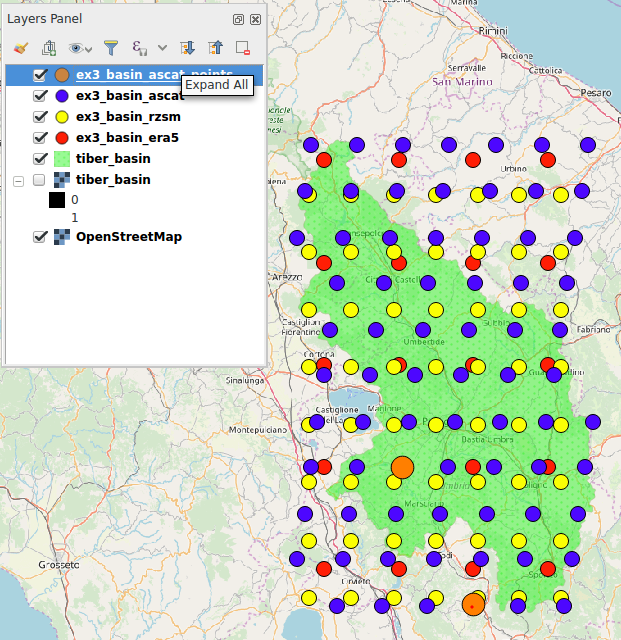

#### 1. ASCAT Time-series extraction

In [93]:
# Get ASCAT time-series data
ts_ascat_id1 = reader_ascat.read_ts(gpi_ascat_id1)
ts_ascat_id2 = reader_ascat.read_ts(gpi_ascat_id2)
# Select ASCAT time-series period
ts_ascat_id1 = ts_ascat_id1.loc[settings['time_start']:settings['time_end']]
ts_ascat_id2 = ts_ascat_id2.loc[settings['time_start']:settings['time_end']]
# Print ASCAT time-series
print(' === ASCAT TimeSeries 1 : ')
print(ts_ascat_id1.head(n=3)); print(ts_ascat_id1.tail(n=3));  
print(' === ASCAT TimeSeries 2 : ')
print(ts_ascat_id2.head(n=3)); print(ts_ascat_id2.tail(n=3));

 === ASCAT TimeSeries 1 : 
                            proc_flag  conf_flag  corr_flag    sm  sat_id  \
2007-01-02 20:42:50.630400          0          0          0  0.30       3   
2007-01-04 08:38:29.961599          0          0          0  0.15       3   
2007-01-05 09:57:48.787200          0          0          0  0.41       3   

                            ssf  dir  sm_noise  snow_prob  frozen_prob  \
2007-01-02 20:42:50.630400    1    0         4          0           11   
2007-01-04 08:38:29.961599    1    1         4          0            7   
2007-01-05 09:57:48.787200    1    1         4          0            4   

                            abs_sm_gldas  abs_sm_noise_gldas  abs_sm_hwsd  \
2007-01-02 20:42:50.630400           NaN                 NaN          NaN   
2007-01-04 08:38:29.961599           NaN                 NaN          NaN   
2007-01-05 09:57:48.787200           NaN                 NaN          NaN   

                            abs_sm_noise_hwsd  
2007-01-02

#### 2. ERA5 Time-series extraction

In [94]:
# Get ERA5 time-series data
ts_era5_id1 = reader_era5.read_ts(gpi_era5_id1)
ts_era5_id2 = reader_era5.read_ts(gpi_era5_id2)
# Select ERA5 time-series period
ts_era5_id1 = ts_era5_id1.loc[settings['time_start']:settings['time_end']]
ts_era5_id2 = ts_era5_id2.loc[settings['time_start']:settings['time_end']]
# Print ERA5 time-series
print(' === ERA5 TimeSeries 1 : ')
print(ts_era5_id1.head(n=3)); print(ts_era5_id1.tail(n=3));  
print(' === ERA5 TimeSeries 2 : ')
print(ts_era5_id2.head(n=3)); print(ts_era5_id2.tail(n=3));

 === ERA5 TimeSeries 1 : 
                        skt   tp
2012-08-01 00:00:00  295.25 -0.0
2012-08-01 01:00:00  294.75 -0.0
2012-08-01 02:00:00  294.00 -0.0
                        skt        tp
2012-10-31 21:00:00  284.00  2.725601
2012-10-31 22:00:00  284.00  1.704216
2012-10-31 23:00:00  284.25  0.673294
 === ERA5 TimeSeries 2 : 
                        skt   tp
2012-08-01 00:00:00  292.25 -0.0
2012-08-01 01:00:00  292.00 -0.0
2012-08-01 02:00:00  291.25 -0.0
                        skt        tp
2012-10-31 21:00:00  282.00  2.254486
2012-10-31 22:00:00  281.75  1.569748
2012-10-31 23:00:00  282.00  0.249386


#### 3. RZSM Time-series extraction

In [95]:
# Get RZSM time-series data
ts_rzsm_id1 = reader_rzsm.read_ts(gpi_rzsm_id1)
ts_rzsm_id2 = reader_rzsm.read_ts(gpi_rzsm_id2)
# Select RZSM time-series period
ts_rzsm_id1 = ts_rzsm_id1.loc[settings['time_start']:settings['time_end']]
ts_rzsm_id2 = ts_rzsm_id2.loc[settings['time_start']:settings['time_end']]
# Print RZSM time-series
print(' === RZSM TimeSeries 1 : ')
print(ts_rzsm_id1.head(n=3)); print(ts_rzsm_id1.tail(n=3));  
print(' === RZSM TimeSeries 2 : ')
print(ts_rzsm_id2.head(n=3)); print(ts_rzsm_id2.tail(n=3));

 === RZSM TimeSeries 1 : 
               var42     var43     var40     var41
2007-01-01  0.710297  0.727356  0.730682  0.763306
2007-01-02  0.710968  0.727295  0.784943  0.758942
2007-01-03  0.710449  0.727234  0.759064  0.759064
               var42     var43     var40     var41
2014-12-29  0.899323  0.832947  0.802246  0.937836
2014-12-30  0.901245  0.833954  0.595154  0.920044
2014-12-31  0.901062  0.834900  0.423096  0.889252
 === RZSM TimeSeries 2 : 
               var42     var43     var40     var41
2007-01-01  0.626190  0.714294  0.700836  0.742920
2007-01-02  0.627808  0.714203  0.761688  0.741394
2007-01-03  0.627808  0.714081  0.749146  0.740601
               var42     var43     var40     var41
2014-12-29  0.888702  0.837402  0.793640  0.919617
2014-12-30  0.890503  0.838318  0.544861  0.899658
2014-12-31  0.890564  0.839264  0.360382  0.834015


### Resample datasets to the same frequency (daily)
* ASCAT --> daily
* ERA5 --> hourly
* RZSM --> daily

In [96]:
# Resample time-series 1 to daily values
ts_resample_id1 = pd.DataFrame()
ts_resample_id1['sm'] = ts_ascat_id1.sm.resample('D').mean().dropna()
ts_resample_id1['sm_noise'] = ts_ascat_id1.sm_noise.resample('D').min().dropna()
ts_resample_id1['snow_prob'] = ts_ascat_id1.snow_prob.resample('D').min().dropna()
ts_resample_id1['frozen_prob'] = ts_ascat_id1.frozen_prob.resample('D').min().dropna()
ts_resample_id1['var40'] = ts_rzsm_id1.var40.resample('D').mean().dropna()
ts_resample_id1['var41'] = ts_rzsm_id1.var41.resample('D').mean().dropna()
ts_resample_id1['var42'] = ts_rzsm_id1.var42.resample('D').mean().dropna()
ts_resample_id1['var43'] = ts_rzsm_id1.var43.resample('D').mean().dropna()
ts_resample_id1['skt'] = ts_era5_id1.skt.resample('D').mean().dropna()
ts_resample_id1['tp'] = ts_era5_id1.tp.resample('D').sum().dropna()
ts_resample_id1['index'] = ts_resample_id1.index
# Print resampled time-series head
print(ts_resample_id1.head(n=3)); print(ts_resample_id1.tail(n=3)); 

if domain == 'morocco':
    ts_resample_id1['tp'] = ts_resample_id1['tp'] / 1000 # to convert to mm

              sm  sm_noise  snow_prob  frozen_prob     var40     var41  \
2007-01-02  0.30       4.0        0.0         11.0  0.784943  0.758942   
2007-01-04  0.15       4.0        0.0          7.0  0.541901  0.754120   
2007-01-05  0.38       4.0        0.0          4.0  0.705872  0.747345   

               var42     var43  skt  tp      index  
2007-01-02  0.710968  0.727295  NaN NaN 2007-01-02  
2007-01-04  0.710724  0.727173  NaN NaN 2007-01-04  
2007-01-05  0.711060  0.727142  NaN NaN 2007-01-05  
              sm  sm_noise  snow_prob  frozen_prob     var40     var41  \
2014-12-29  0.46       4.0        0.0         18.0  0.802246  0.937836   
2014-12-30  0.27       4.0        0.0          0.0  0.595154  0.920044   
2014-12-31  0.11       4.0        0.0          0.0  0.423096  0.889252   

               var42     var43  skt  tp      index  
2014-12-29  0.899323  0.832947  NaN NaN 2014-12-29  
2014-12-30  0.901245  0.833954  NaN NaN 2014-12-30  
2014-12-31  0.901062  0.834900  NaN

In [97]:
# Resample time-series 2 to daily values
ts_resample_id2 = pd.DataFrame()
ts_resample_id2['sm'] = ts_ascat_id2.sm.resample('D').mean().dropna()
ts_resample_id2['sm_noise'] = ts_ascat_id2.sm_noise.resample('D').min().dropna()
ts_resample_id2['snow_prob'] = ts_ascat_id2.snow_prob.resample('D').min().dropna()
ts_resample_id2['frozen_prob'] = ts_ascat_id2.frozen_prob.resample('D').min().dropna()
ts_resample_id2['var40'] = ts_rzsm_id2.var40.resample('D').mean().dropna()
ts_resample_id2['var41'] = ts_rzsm_id2.var41.resample('D').mean().dropna()
ts_resample_id2['var42'] = ts_rzsm_id2.var42.resample('D').mean().dropna()
ts_resample_id2['var43'] = ts_rzsm_id2.var43.resample('D').mean().dropna()
ts_resample_id2['skt'] = ts_era5_id2.skt.resample('D').mean().dropna()
ts_resample_id2['tp'] = ts_era5_id2.tp.resample('D').sum().dropna()
ts_resample_id2['index'] = ts_resample_id2.index
# Print RZSM time-series
print(ts_resample_id2.head(n=3)); print(ts_resample_id2.tail(n=3)); 

              sm  sm_noise  snow_prob  frozen_prob     var40     var41  \
2007-01-01  0.35       5.0        0.0         11.0  0.700836  0.742920   
2007-01-02  0.26       5.0        0.0         11.0  0.761688  0.741394   
2007-01-07  0.38       5.0        0.0         14.0  0.574585  0.724701   

               var42     var43  skt  tp      index  
2007-01-01  0.626190  0.714294  NaN NaN 2007-01-01  
2007-01-02  0.627808  0.714203  NaN NaN 2007-01-02  
2007-01-07  0.631012  0.713715  NaN NaN 2007-01-07  
              sm  sm_noise  snow_prob  frozen_prob     var40     var41  \
2014-12-28  0.71       5.0        0.0         21.0  0.963470  0.913849   
2014-12-29  0.43       5.0        0.0         25.0  0.793640  0.919617   
2014-12-30  0.26       5.0        0.0         21.0  0.544861  0.899658   

               var42     var43  skt  tp      index  
2014-12-28  0.884399  0.836548  NaN NaN 2014-12-28  
2014-12-29  0.888702  0.837402  NaN NaN 2014-12-29  
2014-12-30  0.890503  0.838318  NaN

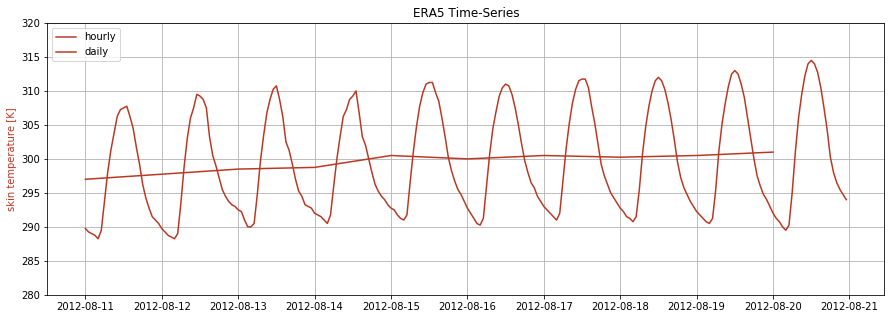

In [98]:
# Plot ERA5 skt and skt resampled variable(s) in same panel with two graphs
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(ts_era5_id2['2012-08-11': '2012-08-20']['skt'], color='#BA3723', label='hourly')
ax.plot(ts_resample_id2['2012-08-11': '2012-08-20']['skt'], color='#BA3723', label='daily')

ax.set_ylim(280, 320)
ax.set_title('ERA5 Time-Series')
ax.set_ylabel('skin temperature [K]', color='#BA3723')
ax.grid(b=True)

plt.legend()

filename = os.path.join(img_path, "ex_ts_skt_cbeck_resampling.tiff")
fig.savefig(filename, dpi=120)

### Compute Soil Water Index (SWI) for ASCAT dataset

In [99]:
# Compute SWI for time-series 1
ts_sm = ts_resample_id1[['sm', 'sm_noise']]
# Get julian dates of time series 1
jd = ts_sm.index.to_julian_date().get_values()
# Calculate SWI T=1,5,10,50
ts_resample_id1['swi_t1'] = exp_filter(ts_sm['sm'].values, jd, ctime=1)
ts_resample_id1['swi_t5'] = exp_filter(ts_sm['sm'].values, jd, ctime=5)
ts_resample_id1['swi_t10'] = exp_filter(ts_sm['sm'].values, jd, ctime=10)
ts_resample_id1['swi_t50'] = exp_filter(ts_sm['sm'].values, jd, ctime=50)
# Print resampled time-series head
print(ts_resample_id1.head(n=3)); print(ts_resample_id1.tail(n=3)); 

              sm  sm_noise  snow_prob  frozen_prob     var40     var41  \
2007-01-02  0.30       4.0        0.0         11.0  0.784943  0.758942   
2007-01-04  0.15       4.0        0.0          7.0  0.541901  0.754120   
2007-01-05  0.38       4.0        0.0          4.0  0.705872  0.747345   

               var42     var43  skt  tp      index    swi_t1    swi_t5  \
2007-01-02  0.710968  0.727295  NaN NaN 2007-01-02  0.300000  0.300000   
2007-01-04  0.710724  0.727173  NaN NaN 2007-01-04  0.167880  0.210197   
2007-01-05  0.711060  0.727142  NaN NaN 2007-01-05  0.317506  0.281918   

             swi_t10  swi_t50  
2007-01-02  0.300000  0.30000  
2007-01-04  0.217525  0.22350  
2007-01-05  0.278937  0.27706  
              sm  sm_noise  snow_prob  frozen_prob     var40     var41  \
2014-12-29  0.46       4.0        0.0         18.0  0.802246  0.937836   
2014-12-30  0.27       4.0        0.0          0.0  0.595154  0.920044   
2014-12-31  0.11       4.0        0.0          0.0  0.42

In [100]:
# Compute SWI for time-series 2
ts_sm = ts_resample_id2[['sm', 'sm_noise']]
# Get julian dates of time series 2
jd = ts_sm.index.to_julian_date().get_values()
# Calculate SWI T=1,5,10,50
ts_resample_id2['swi_t1'] = exp_filter(ts_sm['sm'].values, jd, ctime=1)
ts_resample_id2['swi_t5'] = exp_filter(ts_sm['sm'].values, jd, ctime=5)
ts_resample_id2['swi_t10'] = exp_filter(ts_sm['sm'].values, jd, ctime=10)
ts_resample_id2['swi_t50'] = exp_filter(ts_sm['sm'].values, jd, ctime=50)

### Scaling of the two time-series using mean-std method

In [101]:
# Scale swi (swi_t5, var40)
ts_resample_id1['swi_t5_scaled'] = scaling_method_ms(ts_resample_id1['swi_t5'], ts_resample_id1['var40'])
# Print time-series head
print(ts_resample_id1.head(n=3)); print(ts_resample_id1.tail(n=3)); 

              sm  sm_noise  snow_prob  frozen_prob     var40     var41  \
2007-01-02  0.30       4.0        0.0         11.0  0.784943  0.758942   
2007-01-04  0.15       4.0        0.0          7.0  0.541901  0.754120   
2007-01-05  0.38       4.0        0.0          4.0  0.705872  0.747345   

               var42     var43  skt  tp      index    swi_t1    swi_t5  \
2007-01-02  0.710968  0.727295  NaN NaN 2007-01-02  0.300000  0.300000   
2007-01-04  0.710724  0.727173  NaN NaN 2007-01-04  0.167880  0.210197   
2007-01-05  0.711060  0.727142  NaN NaN 2007-01-05  0.317506  0.281918   

             swi_t10  swi_t50  swi_t5_scaled  
2007-01-02  0.300000  0.30000       0.609978  
2007-01-04  0.217525  0.22350       0.518796  
2007-01-05  0.278937  0.27706       0.591619  
              sm  sm_noise  snow_prob  frozen_prob     var40     var41  \
2014-12-29  0.46       4.0        0.0         18.0  0.802246  0.937836   
2014-12-30  0.27       4.0        0.0          0.0  0.595154  0.920044

In [102]:
# Scale swi (swi_t5, var40)
ts_resample_id2['swi_t5_scaled'] = scaling_method_ms(ts_resample_id2['swi_t5'], ts_resample_id2['var40'])
# Print time-series head
print(ts_resample_id2.head(n=3)); print(ts_resample_id2.tail(n=3)); 

              sm  sm_noise  snow_prob  frozen_prob     var40     var41  \
2007-01-01  0.35       5.0        0.0         11.0  0.700836  0.742920   
2007-01-02  0.26       5.0        0.0         11.0  0.761688  0.741394   
2007-01-07  0.38       5.0        0.0         14.0  0.574585  0.724701   

               var42     var43  skt  tp      index    swi_t1    swi_t5  \
2007-01-01  0.626190  0.714294  NaN NaN 2007-01-01  0.350000  0.350000   
2007-01-02  0.627808  0.714203  NaN NaN 2007-01-02  0.284205  0.300515   
2007-01-07  0.631012  0.713715  NaN NaN 2007-01-07  0.379125  0.348137   

             swi_t10   swi_t50  swi_t5_scaled  
2007-01-01  0.350000  0.350000       0.712793  
2007-01-02  0.302752  0.304550       0.672383  
2007-01-07  0.338592  0.331576       0.711272  
              sm  sm_noise  snow_prob  frozen_prob     var40     var41  \
2014-12-28  0.71       5.0        0.0         21.0  0.963470  0.913849   
2014-12-29  0.43       5.0        0.0         25.0  0.793640  0.91

### Plot time-series

#### 1. Plot ERA5 variables (tp: total precipitation, skt: skin temperature)

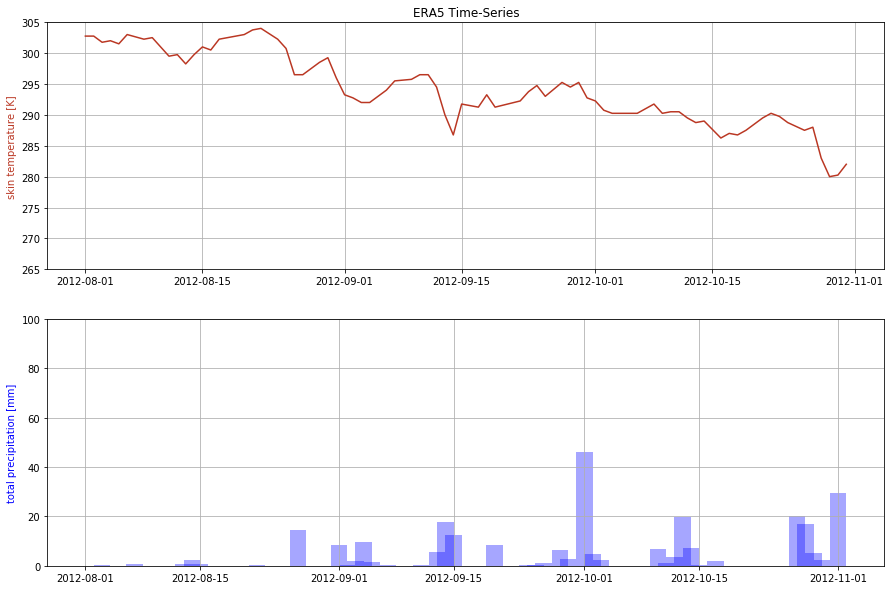

In [103]:
# Plot ERA5 skt and tp variable(s) in same panel with two graphs
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
axs[0].plot(ts_resample_id1['skt'], color='#BA3723')
axs[1].bar(ts_resample_id1['tp'].index, ts_resample_id1['tp'].values, color='#0000FF', alpha=0.35, width=2, align='edge')

axs[0].set_ylim(265, 305)
axs[0].set_title('ERA5 Time-Series')
axs[0].set_ylabel('skin temperature [K]', color='#BA3723')
axs[0].grid(b=True)

axs[1].set_ylim(0, 100)
axs[1].set_ylabel('total precipitation [mm]', color='#0000FF')
axs[1].grid(b=True) 

filename = os.path.join(img_path, "ex_ts_skt_tp.tiff")
fig.savefig(filename, dpi=120)

#### 2. Plot ASCAT and ERA5 soil moisture variables (sm vs var40)

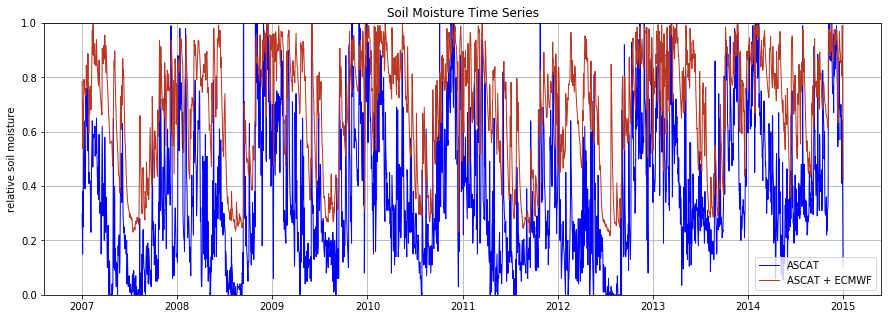

In [104]:
# Plot ASCAT and RZSM soil moisture variable(s)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(ts_resample_id1['sm'], lw=1, color='#0000FF', label='ASCAT')
ax.plot(ts_resample_id1['var40'], lw=1, color='#BA3723', label='ASCAT + ECMWF')

ax.set_ylim(0, 1)
ax.set_title('Soil Moisture Time Series')
ax.set_ylabel('relative soil moisture')
ax.grid(b=True)
plt.legend()

filename = os.path.join(img_path, "ex_ts_sm_var40.tiff")
fig.savefig(filename, dpi=120)

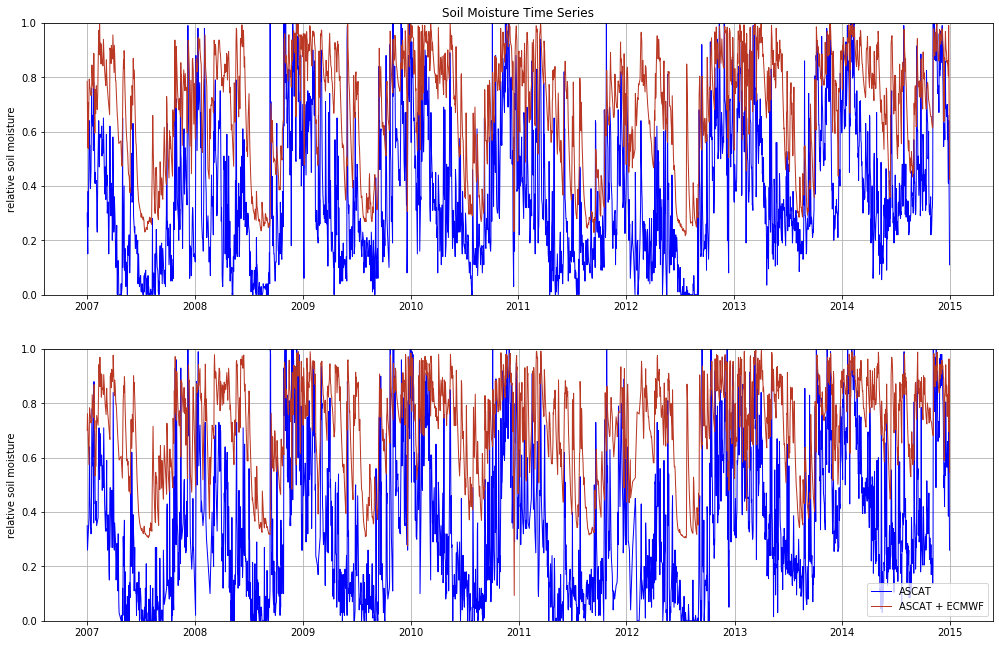

In [105]:
# Plot ASCAT and RZSM soil moisture variable(s) for two gpis
fig, axs = plt.subplots(2, 1, figsize=(17, 11))
axs[0].plot(ts_resample_id1['sm'], lw=1, color='#0000FF', label='ASCAT')
axs[0].plot(ts_resample_id1['var40'], lw=1, color='#BA3723', label='ASCAT + ECMWF')

axs[1].plot(ts_resample_id2['sm'], lw=1, color='#0000FF', label='ASCAT')
axs[1].plot(ts_resample_id2['var40'], lw=1, color='#BA3723', label='ASCAT + ECMWF')

axs[0].set_ylim(0, 1)
axs[0].set_title('Soil Moisture Time Series')
axs[0].set_ylabel('relative soil moisture')
axs[0].grid(b=True)
plt.legend()

axs[1].set_ylim(0, 1)
axs[1].set_ylabel('relative soil moisture')
axs[1].grid(b=True)
plt.legend()

filename = os.path.join(img_path, "ex_ts_sm_var40_2gpis.tiff")
fig.savefig(filename, dpi=120)

### Subset (zoom) for ASCAT, ERA5 and RZSM time-series
* Select time window to plot datasets
* Modify time_start_period and time_end_period

In [106]:
# Extract ASCAT, ERA5 amd RZSM data by period
time_start_period = "2012-08-01"
time_end_period = "2012-10-31"
ts_resample_period_id1 = ts_resample_id1.loc[time_start_period:time_end_period]
ts_resample_period_id2 = ts_resample_id2.loc[time_start_period:time_end_period]
# Print resampled time-series period
print(ts_resample_period_id1.head(n=3)); print(ts_resample_period_id1.tail(n=3)); 

               sm  sm_noise  snow_prob  frozen_prob     var40     var41  \
2012-08-01  0.005       4.0        0.0          0.0  0.374756  0.546783   
2012-08-02  0.000       4.0        0.0          0.0  0.347290  0.533661   
2012-08-03  0.000       4.0        0.0          0.0  0.320801  0.520721   

               var42     var43     skt        tp      index    swi_t1  \
2012-08-01  0.521484  0.688538  302.75  0.000000 2012-08-01  0.003535   
2012-08-02  0.519806  0.687958  302.75  0.133157 2012-08-02  0.001227   
2012-08-03  0.517975  0.687347  301.75  0.000000 2012-08-03  0.000442   

              swi_t5   swi_t10   swi_t50  swi_t5_scaled  
2012-08-01  0.004526  0.010799  0.114506       0.309966  
2012-08-02  0.003556  0.009563  0.111699       0.308981  
2012-08-03  0.002818  0.008489  0.108974       0.308232  
              sm  sm_noise  snow_prob  frozen_prob     var40     var41  \
2012-10-29  0.61       4.0        0.0          0.0  0.938843  0.842834   
2012-10-30  0.65       4.0

### Plot time-series

#### 1. Plot ASCAT and ERA5 soil moisture variables (sm vs var40)

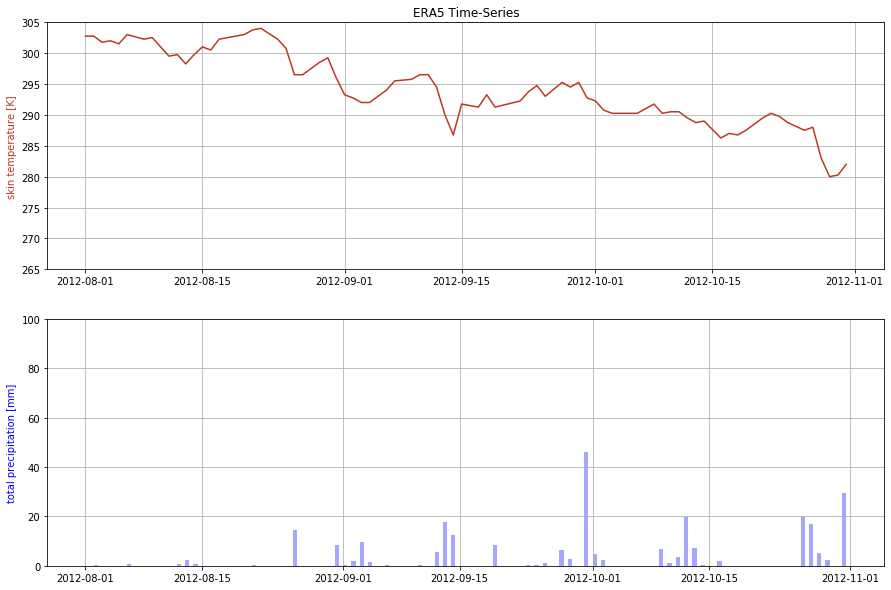

In [107]:
# Plot ERA5 skt and tp variable(s) in same panel with two graphs
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
axs[0].plot(ts_resample_period_id1['skt'], color='#BA3723')
axs[1].bar(ts_resample_period_id1['tp'].index, ts_resample_period_id1['tp'].values, color='#0000FF', alpha=0.35, width=0.5, align='edge')

axs[0].set_ylim(265, 305)
axs[0].set_title('ERA5 Time-Series')
axs[0].set_ylabel('skin temperature [K]', color='#BA3723')
axs[0].grid(b=True)

axs[1].set_ylim(0, 100)
axs[1].set_ylabel('total precipitation [mm]', color='#0000FF')
axs[1].grid(b=True) 

filename = os.path.join(img_path, "ex_ts_skt_tp_period.tiff")
fig.savefig(filename, dpi=120)

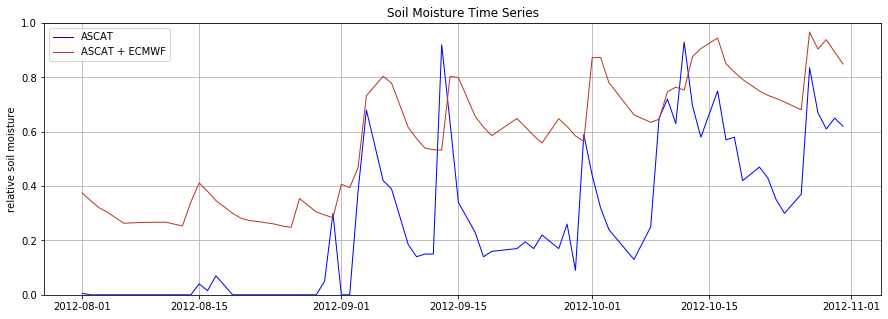

In [108]:
# Plot ASCAT and RZSM soil moisture variable(s)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(ts_resample_period_id1['sm'], lw=1, color='#0000FF', label='ASCAT')
ax.plot(ts_resample_period_id1['var40'], lw=1, color='#BA3723', label='ASCAT + ECMWF')

ax.set_ylim(0, 1)
ax.set_title('Soil Moisture Time Series')
ax.set_ylabel('relative soil moisture')
ax.grid(b=True)
plt.legend()

filename = os.path.join(img_path, "ex_ts_sm_var40_period.tiff")
fig.savefig(filename, dpi=120)

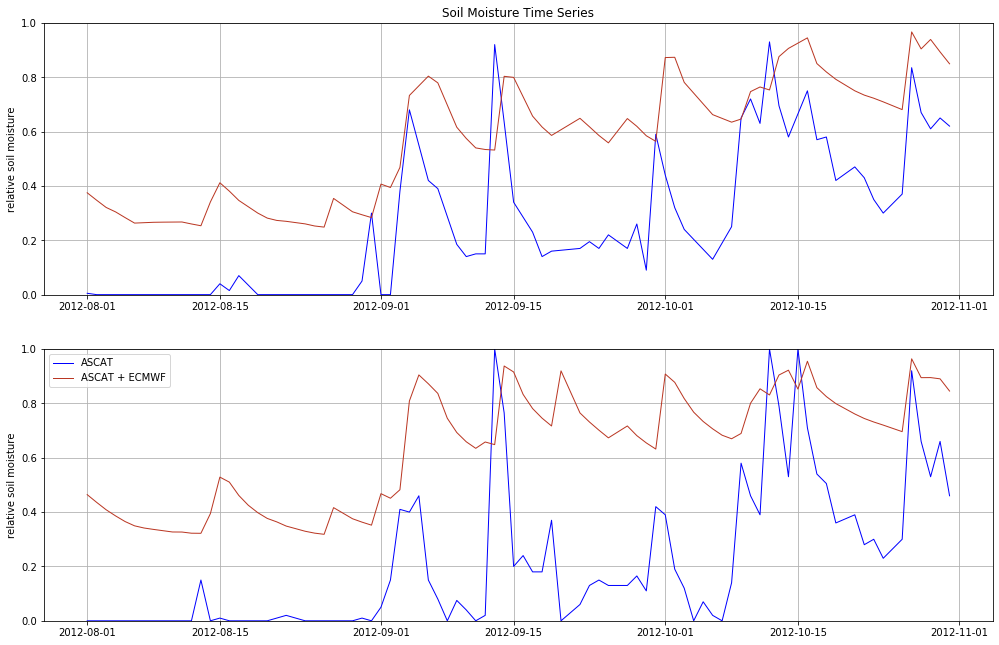

In [109]:
# Plot ASCAT and RZSM soil moisture variable(s) for two gpis
fig, axs = plt.subplots(2, 1, figsize=(17, 11))
axs[0].plot(ts_resample_period_id1['sm'], lw=1, color='#0000FF', label='ASCAT')
axs[0].plot(ts_resample_period_id1['var40'], lw=1, color='#BA3723', label='ASCAT + ECMWF')

axs[1].plot(ts_resample_period_id2['sm'], lw=1, color='#0000FF', label='ASCAT')
axs[1].plot(ts_resample_period_id2['var40'], lw=1, color='#BA3723', label='ASCAT + ECMWF')

axs[0].set_ylim(0, 1)
axs[0].set_title('Soil Moisture Time Series')
axs[0].set_ylabel('relative soil moisture')
axs[0].grid(b=True)
plt.legend()

axs[1].set_ylim(0, 1)
axs[1].set_ylabel('relative soil moisture')
axs[1].grid(b=True)
plt.legend()

filename = os.path.join(img_path, "ex_ts_sm_var40_period_2gpis.tiff")
fig.savefig(filename, dpi=120)

#### 2. Plot ASCAT ssm and soil water index at different T

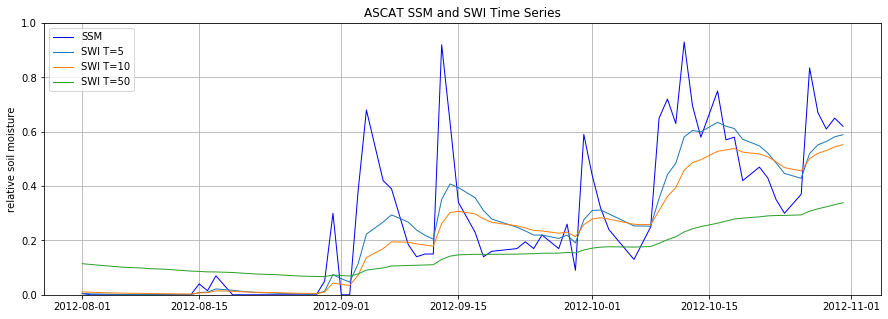

In [110]:
# Plot ASCAT SSM, SWI-T5, SWI-T10, SWI-T50 variable(s)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(ts_resample_period_id1['sm'], lw=1, color='#0000FF', label='SSM')
ax.plot(ts_resample_period_id1['swi_t5'], lw=1, label='SWI T=5')
ax.plot(ts_resample_period_id1['swi_t10'], lw=1, label='SWI T=10')
ax.plot(ts_resample_period_id1['swi_t50'], lw=1, label='SWI T=50')

ax.set_ylim(0, 1)
ax.set_title('ASCAT SSM and SWI Time Series')
ax.set_ylabel('relative soil moisture')
ax.grid(b=True)
plt.legend()

filename = os.path.join(img_path, "ex_ts_sm_swit5-10-50_period.tiff")
fig.savefig(filename, dpi=120)

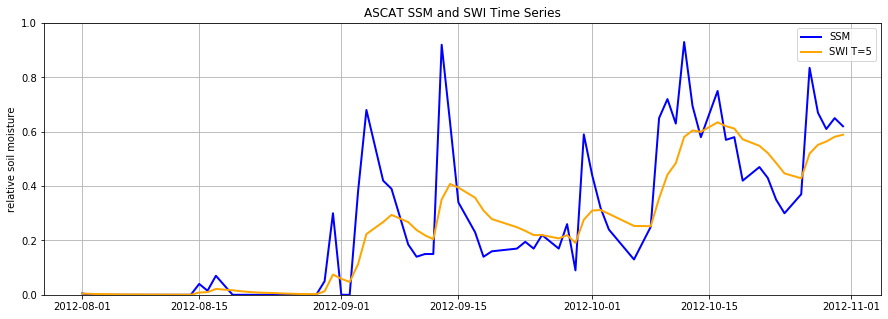

In [111]:
# Plot ASCAT SSM, SWI-T5, SWI-T10, SWI-T50 variable(s)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(ts_resample_period_id1['sm'], lw=2, color='#0000FF', label='SSM')
ax.plot(ts_resample_period_id1['swi_t5'], lw=2, label='SWI T=5', color='#FFA500')

ax.set_ylim(0, 1)
ax.set_title('ASCAT SSM and SWI Time Series')
ax.set_ylabel('relative soil moisture')
ax.grid(b=True)
plt.legend()

filename = os.path.join(img_path, "ex_ts_sm_swit5_period.tiff")
fig.savefig(filename, dpi=120)

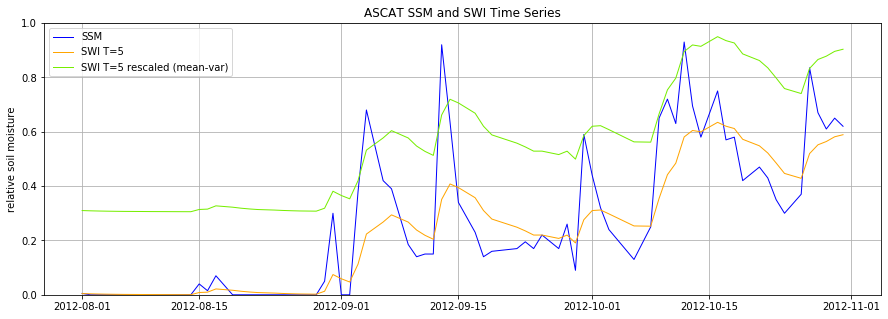

In [112]:
# Plot ASCAT SSM, SWI-T5, SWI-T10, SWI-T50 variable(s)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(ts_resample_period_id1['sm'], lw=1, color='#0000FF', label='SSM')
ax.plot(ts_resample_period_id1['swi_t5'], lw=1, label='SWI T=5', color='#FFA500')
ax.plot(ts_resample_period_id1['swi_t5_scaled'], lw=1, color='#76EE00', label='SWI T=5 rescaled (mean-var)')

ax.set_ylim(0, 1)
ax.set_title('ASCAT SSM and SWI Time Series')
ax.set_ylabel('relative soil moisture')
ax.grid(b=True)
plt.legend()

filename = os.path.join(img_path, "ex_ts_sm_swit5_swit5scale_period.tiff")
fig.savefig(filename, dpi=120)

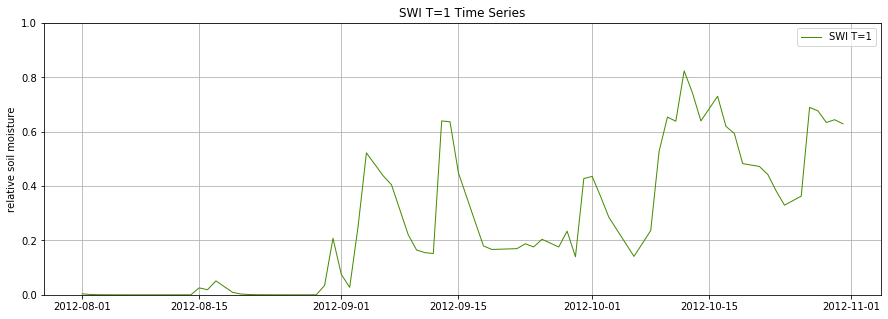

In [113]:
# Plot ASCAT SWI T=1 timeseries
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
axs.plot(ts_resample_period_id1['swi_t1'], lw=1, color='#458B00', label='SWI T=1')

axs.set_ylim(0, 1)
axs.set_title('SWI T=1 Time Series')
axs.set_ylabel('relative soil moisture')
axs.grid(b=True)

plt.legend()

filename = os.path.join(img_path, "ex_ts_sm_swit1_period.tiff")
fig.savefig(filename, dpi=120)

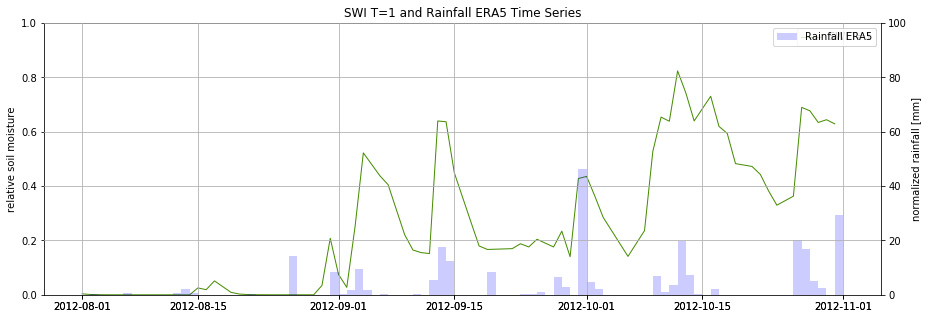

In [114]:
# Plot ASCAT SWI T=1 and ERA5 Rainfall timeseries
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(111)
ax1.plot(ts_resample_period_id1['swi_t1'], lw=1, color='#458B00', label = 'SWI T=1')
ax1.set_ylim(0, 1)
ax1.legend()

plt.title('SWI T=1 and Rainfall ERA5 Time Series')
plt.ylabel("relative soil moisture")

ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.bar(ts_resample_period_id1['tp'].index, ts_resample_period_id1['tp'].values, 
              label = 'Rainfall ERA5', color='#0000FF', alpha=0.2, width=1, align='edge')
ax2.set_ylim(0, 100)
ax2.legend()

plt.ylabel("normalized rainfall [mm]")

plt.grid()

filename = os.path.join(img_path, "ex_ts_sm_swit1_tp_period.tiff")
fig.savefig(filename, dpi=120)

#### On-the-job Training:
* Visualization and comparison of soil moisture time series at one point
* Visualization and comparison of time series at two points in the study area
* Analysis of the periods (in time) to be masked out due to frozen conditions (if any), suspicious and missing data
* Application of the Soil Water Index to ASCAT soil moisture products for different T-values
* Application of rescaling techniques to make soil moisture time series in the same range of values
* Comparison of precipitation and soil moisture time series